# Community Housing survey Project (CHP) Dimensionality Reduction and Clustering
The goal of this notebook is to apply dimensionality reduction to the 2020 PhD-Community Initiative Housing Survey dataset followed by clustering methods to observe distinct groups in the community survey. 

Dimensionality reduction has the benefit to easily visualizing the aggregate result of over a dozen questions participants in the survey had to fill out. It attempts to reduce this high dimensional data set down into its principle components, or factors, that account for the greatest variance in the data. We can then visualize the extent to which various questions contribute to these components by plotting the loading, or "influence" each question has on the component.

Following this approach, we can easily apply a 2-D clustering method such as k-means to identify clusters of survey respondents who have similar component scores, in essence, identifying participants who answered similarly across multiple questions.

Coded by Josh Moskowitz in February 2020

---


Import the relevant libraries and other setup

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup
%matplotlib inline
pd.set_option('display.max_columns', None)

Import survey data

In [29]:
#survey = pd.read_excel('F:/Users/Josh/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
survey = pd.read_excel('C:/Users/Josh/Desktop/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
questions = survey.iloc[0][:] # grab question wording and store for later

## Cleanup survey data

Remove unecessary rows and cols

In [30]:
survey.drop(index=[0,1],inplace=True) # remove first 2 rows
# Remove any irrelevant or personally idenitifying columns
survey.drop(labels=['Status','IPAddress','RecipientLastName','RecipientFirstName','RecipientEmail',
                    'ExternalReference','LocationLatitude','LocationLongitude','DistributionChannel',
                    'UserLanguage','info','consent','StartDate','EndDate','Duration (in seconds)',
                    'Progress','Finished','RecordedDate','ResponseId','num_applied_explain_2_TEXT',
                    'num_applied_explain_3_TEXT','current_living_arr_6_TEXT','why_move_7_TEXT',
                    'fam_status_5_TEXT','can_residency_3_TEXT','why_move','num_applied',
                    'num_applied_explain','private_housing','subsidy',
                   ],axis=1,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

Remove Whitespace and weird characters

In [31]:
def cleanDataFrame(obj):
    "Return a modified string"
    if isinstance(obj, str): # if object is a string
        return obj.replace("â€™", "'").strip() # fix apostrophes and remove trailing whitespace
    else:
        return obj

survey = survey.applymap(cleanDataFrame)

Function that will strip commas and split string when a person gave multiple responses

In [32]:
def cleanAndSplit(string):
    "Return a list of strings split by comma"
    
    # remove commas from one of the possible survey responses
    # "I need to be closer to work, childcare, or social/health support services"
    if "I need to be closer to work" in string:
        idx1 = string.find("childcare") - 2
        idx2 = string.find(" or ") - 1
        cleanString = string[:idx1] + string[idx1:idx2].replace(',','') + string[idx2+1:]
    else:
        cleanString = string

    return cleanString.split(',')

Function that will recode the employment column to only include one employment type

In [33]:
def recodeEmploy(row):
    "Return a Pandas row object with modified employment data"
    
    if isinstance(row.employment,str):
        listStatus = cleanAndSplit(row.employment)
        # we don't care if students are employed or not
        if 'Student' in listStatus:
            row.employment = 'Student'
        # we don't care if retirees are employed or not
        elif 'Retired' in listStatus:
            row.employment = 'Retired'
        else:
            row.employment = listStatus[0]
    return row
survey = survey.apply(recodeEmploy,axis='columns')

In [34]:
list(survey.columns) # check col names

['current_living_arr',
 'employment',
 'income_stable',
 'utilities',
 'debt',
 'mental_health',
 'substance_use',
 'gender',
 'age',
 'fam_status',
 'first_nation',
 'vis_minority',
 'can_residency']

# Prepare data for PCA
---
### Notes
Try using CountVectorizer() to encode 'why_move' column

In [35]:
# imports
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [36]:
survey.isna().sum() # cols with NaNs

current_living_arr    1
employment            1
income_stable         1
utilities             3
debt                  1
mental_health         1
substance_use         1
gender                1
age                   1
fam_status            1
first_nation          1
vis_minority          1
can_residency         1
dtype: int64

In [37]:
# Find where common empty rows are and drop from table
idx = survey[survey.age.isna()]['age'].index.values
survey.drop(index=idx,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

### SimpleImputer
As we're missing responses for one or more variables we're going to impute the missing values as simply the most frequent value present in that column.

---

In [38]:
# For missing utilities data impute values
si = SimpleImputer(strategy='most_frequent')
col = np.reshape(survey.utilities.values,(-1,1)) # need to do this for single cols apparently
surveyProc = pd.DataFrame(si.fit_transform(col)).rename(columns={0:'utilities'}) # replace missing col name
survey.drop(labels='utilities',axis=1,inplace=True) # remove original column
survey = survey.join(surveyProc);

### Select columns to be encoded

---

In [39]:
# Select columns
oeCols = ['income_stable','utilities','mental_health','substance_use']
ohCols = [col for col in survey.drop(labels=oeCols,axis=1).columns] # all other cols

### One-Hot Encoding using ColumnTransformer
We're going to take any nominal data and apply "one-hot encoding". For each possible question response (i.e. Male or Female for "What is your gender?") we're going to create a new column in a dataframe and fill its rows with 1s where a survey participant chose that response and 0s otherwise.

---

In [40]:
# One-Hot encoding
ct = ColumnTransformer(
[('oh', OneHotEncoder(sparse=False,handle_unknown='ignore'), ohCols)],
    remainder='drop')
surveyOH = pd.DataFrame(ct.fit_transform(survey),dtype=int)
surveyOH.columns = ct.get_feature_names() # assign col names

### OrdinalEncoder 
For the ordinal variables which have a rank order (e.g. "Do much do you struggle with mental illnes?") we will encode the different responses according to an order that assumes linear differences between possible responses (e.g. 0 would be "struggle a lot" and 4 would be "hardly at all").

---

In [41]:
# going to be used for ordinal encoder categories param
# align such that index 0 --> 4 corresponds to increasing difficulty with issues 
orders = [['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable'],
          ['Never','Occasionally','Sometimes','Frequently','Always'],
          ['Not at all','A little','A moderate amount','A lot',
          'A great deal','Prefer not to answer'],
          ['Not at all','A little','A moderate amount','A lot',
          'A great deal','Prefer not to answer']]

In [42]:
# OrdinalEncoding
# Can't use a ColumnTransformer because I want to pass different category parameters to OrdinalEncoder()
def OrdinalEncode(colName,categories):
    "Returns a dataframe after performing ordinal encoding"
    oe = OrdinalEncoder(categories=[categories])
    col = np.reshape(survey[colName].values,(-1,1)) # need to do this for single cols apparently
    return pd.DataFrame(oe.fit_transform(col),dtype=int).rename(columns={0:colName}) # replace missing col name

In [43]:
for i, col in enumerate(oeCols): # for each col to be ordinal encoded
    df = OrdinalEncode(col,orders[i])
    if i == 0:
        surveyOE = df # init dataFrame
    else:
        surveyOE = surveyOE.join(df) # join additional frames
surveyProc = surveyOH.join(surveyOE) # combine to create PCA-ready dataFrame

## Preprocessed survey data ready for dimensionality reduction

In [44]:
surveyProc

,oh__x0_I am in an emergency shelter,oh__x0_I am staying with family and friends,oh__x0_I own my home,oh__x0_I pay full market rent,"oh__x0_I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)","oh__x0_Other (e.g., I am homeless, I live in an institution). Please describe:",oh__x1_Full time employed,oh__x1_Part time employed,oh__x1_Retired,oh__x1_Student,oh__x1_Unemployed,oh__x2_No,oh__x2_Prefer not to answer,oh__x2_Yes,oh__x3_Female,oh__x3_I don't identify within the gender binary,oh__x3_I prefer not to disclose information concerning my gender,oh__x3_Male,oh__x4_25 - 65,oh__x4_Over 65,oh__x4_Under 25,oh__x5_Couple with dependents,oh__x5_Couple without dependents,oh__x5_Other:,oh__x5_Single no dependents,oh__x5_Single with dependents,oh__x6_No,oh__x6_Prefer not to say,oh__x6_Yes,oh__x7_No,oh__x7_Prefer not to say,oh__x7_Yes,oh__x8_Canadian Citizen,oh__x8_Other:,oh__x8_Permanent Resident,income_stable,utilities,mental_health,substance_use
0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,2,4,4,0
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,2,4,1
2,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,3,4,0,0
3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,2,0,5,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,2,0
65,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,4,4,5
66,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0
67,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,2,1,5,5


# Run PCA
Now that the data is correctly formatted, run the PCA function using sci-kit learn, to return the 2 principle components that account for the majority of the variance

---

In [45]:
# Fit PCA
pca = PCA(n_components=2)
X = pca.fit_transform(surveyProc)
varExpl = pca.explained_variance_ratio_

Text(0, 0.5, 'PCA 2 (17.0%)')

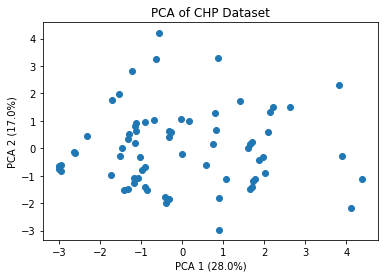

In [46]:
# Plotting
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.title('PCA of CHP Dataset')
plt.xlabel("PCA 1 ({}%)".format(round(varExpl[0]*100)))
plt.ylabel("PCA 2 ({}%)".format(round(varExpl[1]*100)))

In [47]:
cat = [col for col in surveyProc.columns.values] # x-val
loadings = pca.components_ # PCA loadings
loadingsPC1 = loadings[0,:] # PCA1
loadingsPC2 = loadings[1,:] # PCA2

Text(0.5, 1.0, 'Loadings for PCA 1')

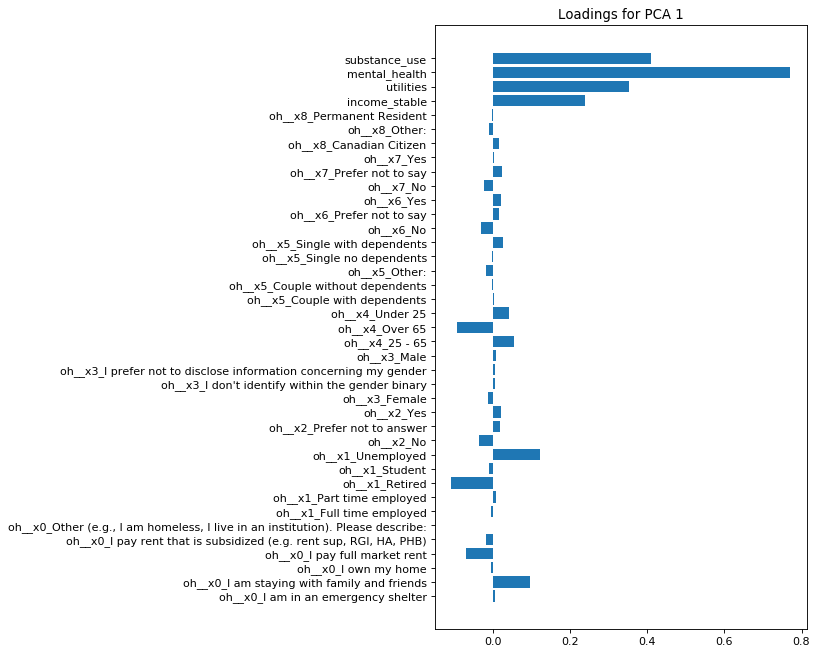

In [48]:
# Plotting
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC1)
plt.title('Loadings for PCA 1')

Text(0.5, 1.0, 'Loadings for PCA 2')

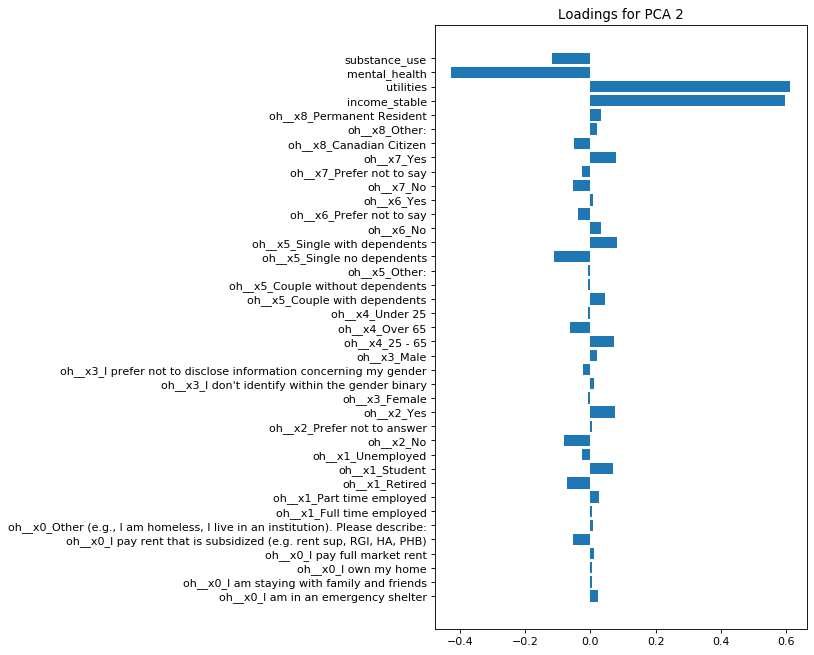

In [49]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC2)
plt.title('Loadings for PCA 2')

---
It would appear that a standard PCA approach was not effective at finding clusters in the data. This is likely because binarized data (i.e. one-hot encoded) is not designed to be used in a PCA. I will now try using Multiple correspondence analysis (MCA) instead the *prince* Python package

In [50]:
import prince

In [51]:
mca = prince.MCA(
n_components = 2,
n_iter=3,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
with warnings.catch_warnings(): # was giving me lots of warnings, so suppress
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    mca = mca.fit(surveyProc)
    # Plotting
    ax = mca.plot_coordinates(
    X=surveyProc,
    ax=None,
    figsize=(6,6),
    show_row_points=True,
    row_points_size=30,
    show_row_labels=False,
    show_column_points=False,
    column_points_size=30,
    show_column_labels=False,
    legend_n_cols=1
    )

NameError: name 'warnings' is not defined

Still didn't work great, what if we drop variables that we think will have low impact on our resulting PCA (based on the exploratory analysis)? Let's try again with only the most promising variables

In [ ]:
oeCols = ['income_stable','utilities','mental_health']
ohCols = ['current_living_arr','employment','fam_status']

In [ ]:
# One-Hot encoding
ct = ColumnTransformer(
[('oh', OneHotEncoder(sparse=False,handle_unknown='ignore'), ohCols)],
    remainder='drop')
surveyOH = pd.DataFrame(ct.fit_transform(survey),dtype=int)
surveyOH.columns = ct.get_feature_names() # assign col names

In [ ]:
for i, col in enumerate(oeCols): # for each col to be ordinal encoded
    df = OrdinalEncode(col,orders[i])
    if i == 0:
        surveyOE = df # init dataFrame
    else:
        surveyOE = surveyOE.join(df) # join additional frames
surveyProc = surveyOH.join(surveyOE) # combine to create PCA-ready dataFrame

In [ ]:
surveyProc

# Run PCA
Now that the data is correctly formatted, run the PCA function using sci-kit learn, to return the 2 principle components that account for the majority of the variance

---

In [ ]:
# Fit PCA
pca = PCA(n_components=2)
X = pca.fit_transform(surveyProc)
varExpl = pca.explained_variance_ratio_

In [ ]:
# Plotting
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.title('PCA of CHP Dataset')
plt.xlabel("PCA 1 ({}%)".format(round(varExpl[0]*100)))
plt.ylabel("PCA 2 ({}%)".format(round(varExpl[1]*100)))

In [ ]:
cat = [col for col in surveyProc.columns.values] # x-val
loadings = pca.components_ # PCA loadings
loadingsPC1 = loadings[0,:] # PCA1
loadingsPC2 = loadings[1,:] # PCA2

In [ ]:
# Plotting
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC1)
plt.title('Loadings for PCA 1')

In [ ]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC2)
plt.title('Loadings for PCA 2')

### MCA

In [ ]:
mca = prince.MCA(
n_components = 2,
n_iter=3,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
with warnings.catch_warnings(): # was giving me lots of warnings, so suppress
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    mca = mca.fit(surveyProc)
    # Plotting
    ax = mca.plot_coordinates(
    X=surveyProc,
    ax=None,
    figsize=(6,6),
    show_row_points=True,
    row_points_size=30,
    show_row_labels=False,
    show_column_points=False,
    column_points_size=30,
    show_column_labels=False,
    legend_n_cols=1
    )

---
Better, but still doesn't seem ideal for clustering, let's try one more approach. We have several variables that we are currently applying one-hot encoding to. Instead, let's try an ordinal encoding that we think is sensible. For example, the variable 'current living arrangement' can be ordered based on a scale of housing security, with *I am homeless* on one end, and *I pay market rent* on the other. We can apply this similar approach to a few other questions to try and generate better data to be used in the PCA/MCA

In [ ]:
livingResp = survey.current_living_arr.unique().tolist()

In [ ]:
# going to be used for ordinal encoder categories param
# align such that index 0 --> 4 corresponds to increasing difficulty with issues 
orders = [['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable'],
          ['Never','Occasionally','Sometimes','Frequently','Always'],
          ['Not at all','A little','A moderate amount','A lot',
          'A great deal','Prefer not to answer'],
          survey.age.unique().tolist(),
          ['Full time employed','Part time employed','Student','Retired','Unemployed'],
          [livingResp[5],livingResp[1],livingResp[0],livingResp[2],livingResp[4],livingResp[3]]]

In [ ]:
oeCols = ['income_stable','utilities','mental_health',
          'age','employment','current_living_arr']
ohCols = ['gender']

In [ ]:
# One-Hot encoding
ct = ColumnTransformer(
[('oh', OneHotEncoder(sparse=False,handle_unknown='ignore'), ohCols)],
    remainder='drop')
surveyOH = pd.DataFrame(ct.fit_transform(survey),dtype=int)
surveyOH.columns = ct.get_feature_names() # assign col names

In [ ]:
for i, col in enumerate(oeCols): # for each col to be ordinal encoded
    df = OrdinalEncode(col,orders[i])
    if i == 0:
        surveyOE = df # init dataFrame
    else:
        surveyOE = surveyOE.join(df) # join additional frames
surveyProc = surveyOH.join(surveyOE) # combine to create PCA-ready dataFrame

In [ ]:
surveyProc

# Run PCA
Now that the data is correctly formatted, run the PCA function using sci-kit learn, to return the 2 principle components that account for the majority of the variance

---

In [ ]:
# Fit PCA
pca = PCA(n_components=2)
X = pca.fit_transform(surveyProc)
varExpl = pca.explained_variance_ratio_

In [ ]:
# Plotting
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.title('PCA of CHP Dataset')
plt.xlabel("PCA 1 ({}%)".format(round(varExpl[0]*100)))
plt.ylabel("PCA 2 ({}%)".format(round(varExpl[1]*100)))

In [ ]:
cat = [col for col in surveyProc.columns.values] # x-val
loadings = pca.components_ # PCA loadings
loadingsPC1 = loadings[0,:] # PCA1
loadingsPC2 = loadings[1,:] # PCA2

In [ ]:
# Plotting
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC1)
plt.title('Loadings for PCA 1')

In [ ]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC2)
plt.title('Loadings for PCA 2')

### MCA

In [ ]:
mca = prince.MCA(
n_components = 2,
n_iter=3,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
with warnings.catch_warnings(): # was giving me lots of warnings, so suppress
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    mca = mca.fit(surveyProc)
    # Plotting
    ax = mca.plot_coordinates(
    X=surveyProc,
    ax=None,
    figsize=(6,6),
    show_row_points=True,
    row_points_size=30,
    show_row_labels=False,
    show_column_points=False,
    column_points_size=30,
    show_column_labels=False,
    legend_n_cols=1
    )